In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text
0  3002\nraM\n81\n1v8243030/hp-ortsa:viXra\nMeasu...
1  THE PHYSICS OF CORE-COLLAPSE\nSUPERNOVAE\nSupe...
2  6002\nceD\n4\n1v2702160/hp-ortsa:viXra\nTheory...
3  2102\nvoN\n6\n]RS.hp-ortsa[\n1v8731.1121:viXra...
4  8102\nraM\n9\n]EH.hp-ortsa[\n2v57810.3081:viXr...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10 non-null     object
dtypes: object(1)
memory usage: 208.0+ bytes
None
                                                     text
count                                                  10
unique                                                 10
top     3002\nraM\n81\n1v8243030/hp-ortsa:viXra\nMeasu...
freq                                                    1


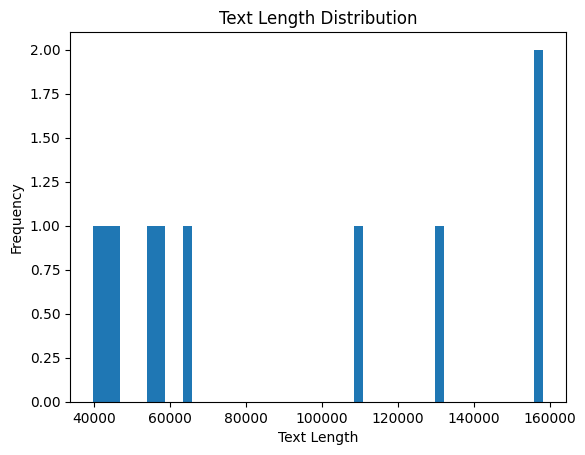

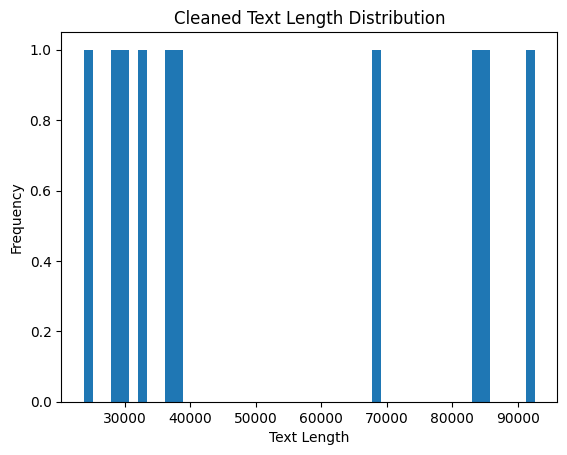

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pdfplumber
import re
import string
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

pdf_paths = ['/content/drive/MyDrive/Supernova/0303428v1.pdf',
             '/content/drive/MyDrive/Supernova/0601261v1.pdf',
             '/content/drive/MyDrive/Supernova/0612072v1.pdf',
             '/content/drive/MyDrive/Supernova/1211.1378v1.pdf',
             '/content/drive/MyDrive/Supernova/1803.01875v2.pdf',
             '/content/drive/MyDrive/Supernova/1805.03207v1.pdf',
             '/content/drive/MyDrive/Supernova/2103.05230v1.pdf',
             '/content/drive/MyDrive/Supernova/2105.00665v2.pdf',
             '/content/drive/MyDrive/Supernova/2312.04621v2.pdf',
             '/content/drive/MyDrive/Supernova/9805201v1.pdf'
             ]

# Extract text from PDFs
def extract_text_from_pdf(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Extract text from all PDFs
all_text = [extract_text_from_pdf(pdf_path) for pdf_path in pdf_paths]

# Create a dataframe with the extracted text
df = pd.DataFrame({'text': all_text})

# Perform EDA
print(df.head())
print(df.info())
print(df.describe())

# Visualize the text length distribution
plt.hist(df['text'].apply(len), bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

# Preprocess the text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(clean_text)

# Visualize the cleaned text length distribution
plt.hist(df['text'].apply(len), bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Cleaned Text Length Distribution')
plt.show()

In [ ]:
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")

# Define the regex patterns
supernova_name_pattern = re.compile(r'\bSN\d{4}[A-Za-z]*\b')
type_pattern = re.compile(r'\bType [I|II][a-c|p|n|l|b]?\b')
luminosity_pattern = re.compile(r'-?\d+\.\d+ mag')
host_galaxy_pattern = re.compile(r'NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|PKS \d+')
redshift_pattern = re.compile(r'z=\d+\.\d+')
distance_pattern = re.compile(r'\d+\.\d+ Mpc')

# Define the NER model
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_uncased")
nlp_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

# Define the rule-based annotation function
def initial_annotation(text):
    annotations = []
    supernova_names = supernova_name_pattern.findall(text)
    types = type_pattern.findall(text)
    luminosities = luminosity_pattern.findall(text)
    host_galaxies = host_galaxy_pattern.findall(text)
    redshifts = redshift_pattern.findall(text)
    distances = distance_pattern.findall(text)
    annotations.extend([("Supernova Name", name) for name in supernova_names])
    annotations.extend([("Type", type_) for type_ in types])
    annotations.extend([("Luminosity", lum) for lum in luminosities])
    annotations.extend([("Host Galaxy", galaxy) for galaxy in host_galaxies])
    annotations.extend([("Redshift", redshift) for redshift in redshifts])
    annotations.extend([("Distance", distance) for distance in distances])
    return annotations

# TOKENIZING AND CHUNKING
def tokenize_and_chunk(text, tokenizer, max_length=512):
    tokens = tokenizer(text, truncation=True, max_length=max_length, return_overflowing_tokens=False, return_tensors='pt')
    input_ids = tokens['input_ids']
    chunks = [tokenizer.decode(input_ids[0][i:i + max_length], skip_special_tokens=True) for i in range(0, len(input_ids[0]), max_length)]
    return chunks

def validate_combined_annotation(annotation):
    return True

# COMBINING THE ANNOTATIONS
def combined_annotation(text):
    if not text.strip():
        return []

    rule_based_anns = initial_annotation(text)
    ner_anns = ner_annotation(text)

    combined_anns = list(set(rule_based_anns + ner_anns))

    valid_annotations = [ann for ann in combined_anns if validate_combined_annotation(ann)]

    return valid_annotations

# Define the NER annotation function
def ner_annotation(text):
    chunks = tokenize_and_chunk(text, tokenizer)
    all_results = []
    for chunk in chunks:
        if chunk.strip():
            results = nlp_pipeline(chunk)
            for result in results:
                word = result['word']
                entity = result['entity']
                label = None
                if "SN" in word:
                    label = "Supernova Name"
                elif "Type" in word:
                    label = "Type"
                elif "mag" in word:
                    label = "Luminosity"
                elif "z=" in word:
                    label = "Redshift"
                elif "Mpc" in word:
                    label = "Distance"
                elif any(prefix in word for prefix in ["NGC", "IC", "Messier", "UGC", "ESO", "PGC", "Mrk", "SDSS", "RX", "2MASX", "PKS"]):
                    label = "Host Galaxy"
                if label:
                    all_results.append((word, label))
    return all_results

# Define the combined annotation function
def combined_annotation(text):
    if not text.strip():
        return []
    rule_based_anns = initial_annotation(text)
    ner_anns = ner_annotation(text)
    combined_anns = list(set(rule_based_anns + ner_anns))
    valid_annotations = [ann for ann in combined_anns if validate_combined_annotation(ann)]
    return valid_annotations

# Process the PDFs
all_annotations = []
for pdf_path in pdf_paths:
    text = extract_text_from_pdf(pdf_path)
    if text.strip():
        annotations = combined_annotation(text)
        all_annotations.extend(annotations)

# Store the entities as records
all_extracted_records = []
current_record = {"Supernova Name": None, "Luminosity": None, "Type": None, "Host Galaxy": None, "Redshift": None, "Distance": None}
for label, entity in all_annotations:
    if label == "Supernova Name":
        if current_record["Supernova Name"] is not None:
            all_extracted_records.append(current_record)
            current_record = {"Supernova Name": None, "Luminosity": None, "Type": None, "Host Galaxy": None, "Redshift": None, "Distance": None}
        current_record["Supernova Name"] = entity
    elif label in current_record:
        current_record[label] = entity
if current_record["Supernova Name"] is not None:
    all_extracted_records.append(current_record)

# Handle missing values and label encoding
for record in all_extracted_records:
    for key in record.keys():
        if record[key] is None:
            if key in ["Luminosity", "Redshift", "Distance"]:
                record[key] = 0.0
            else:
                record[key] = "Unknown"

label_encoders = {}
for key in ["Supernova Name", "Type", "Host Galaxy", "Redshift"]:
    encoder = LabelEncoder()
    values = [record[key] for record in all_extracted_records]
    label_encoders[key] = encoder.fit(values)
    for record in all_extracted_records:
        record[key] = encoder.transform([record[key]])[0]

for record in all_extracted_records:
    record["Luminosity"] = float(record["Luminosity"].replace(" mag", "")) if isinstance(record["Luminosity"], str) else float(record["Luminosity"])
    record["Distance"] = float(record["Distance"].replace(" Mpc", "")) if isinstance(record["Distance"], str) else float(record["Distance"])

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 201ms/step - accuracy: 0.0972 - loss: 2.7450 - val_accuracy: 0.1282 - val_loss: 2.2993
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.1380 - loss: 2.6633 - val_accuracy: 0.1496 - val_loss: 2.3015
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.1618 - loss: 2.5186 - val_accuracy: 0.1581 - val_loss: 2.2684
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.2237 - loss: 2.3094 - val_accuracy: 0.2265 - val_loss: 2.1143
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.3073 - loss: 2.0228 - val_accuracy: 0.3376 - val_loss: 2.0056
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 483ms/step - accuracy: 0.4401 - loss: 1.7155 - val_accuracy: 0.3590 - val_loss: 1.9349
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.5220 - loss: 1.4729 - val_accuracy: 0.4915 - val_loss: 1.7539
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6363 - loss: 1.1683 - val_accurac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,240 (1.15 MB)

 Trainable params: 100,746 (393.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,494 (787.09 KB)

Validation Loss: 1.2553, Validation Accuracy: 0.7265
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.23      0.23        13
           1       0.91      0.84      0.87        37
           2       0.81      0.84      0.82        25
           3       0.81      0.87      0.84        30
           4       0.88      0.70      0.78        20
           5       0.57      0.53      0.55        15
           6       0.71      0.81      0.76        27
           7       0.81      0.62      0.70        34
           8       0.73      0.92      0.81        24
           9       0.17      0.22      0.19         9

    accuracy                           0.73       234
   macro avg       0.66      0.66      0.66       234
weighted avg       0.74      0.73      0.73       234



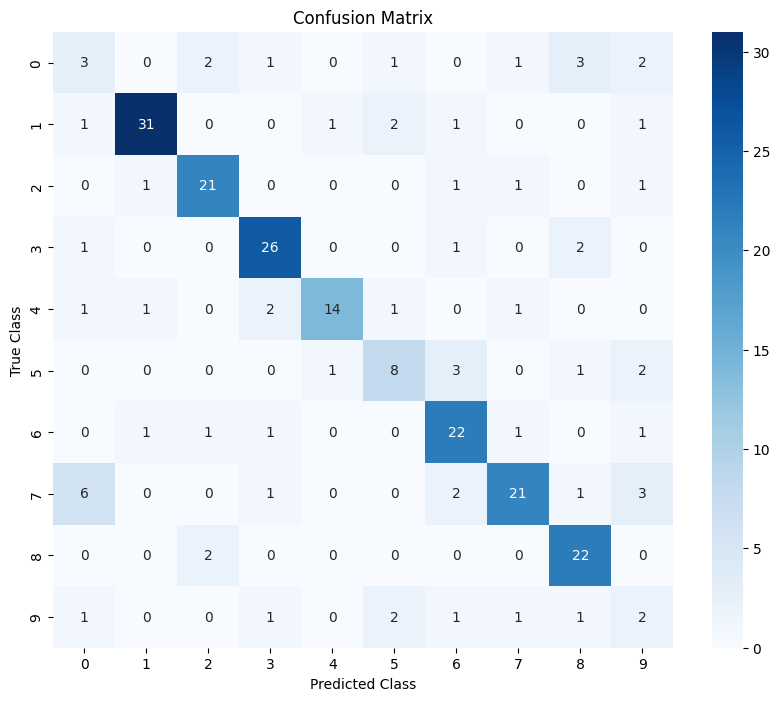

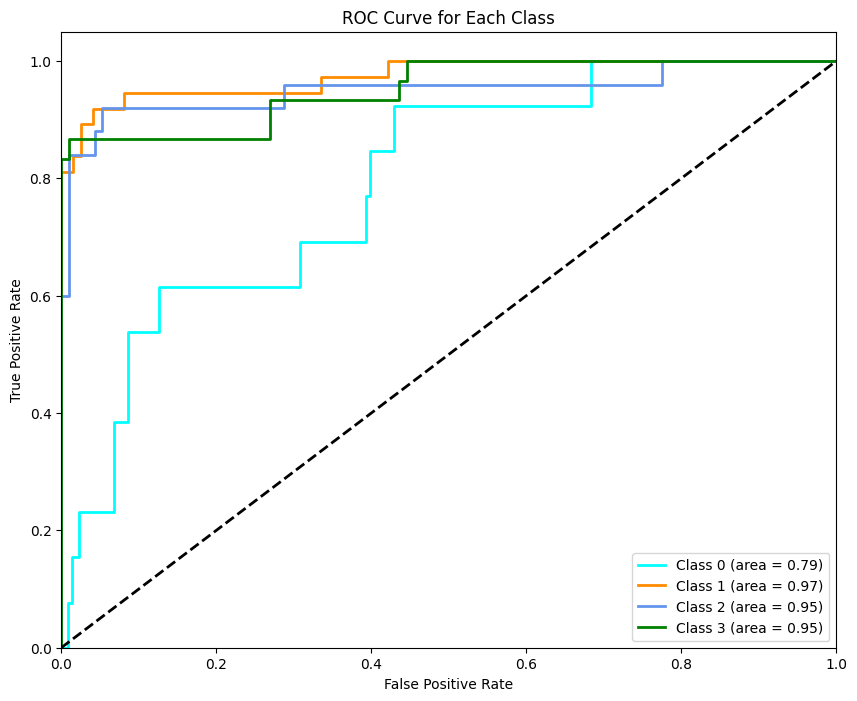

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
X = np.array([[record["Supernova Name"], record["Type"], record["Luminosity"], record["Host Galaxy"], record["Redshift"], record["Distance"]] for record in all_extracted_records])
y = np.array([record["Type"] for record in all_extracted_records])

# Train the model
num_samples = 1000
timesteps = 100
input_dim = 50
num_classes = 10

X = np.random.rand(num_samples, timesteps, input_dim)
y = np.random.randint(0, num_classes, size=(num_samples,))

scaler = StandardScaler()
X_reshaped = X.reshape(-1, input_dim)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, timesteps, input_dim)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled.reshape(num_samples, -1), y)
X_resampled = X_resampled.reshape(-1, timesteps, input_dim)

y_resampled = to_categorical(y_resampled, num_classes=num_classes)

split_idx = int(0.8 * len(X_resampled))
X_train, X_val = X_resampled[:split_idx], X_resampled[split_idx:]
y_train, y_val = y_resampled[:split_idx], y_resampled[split_idx:]

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = {0: 2.0, 1: 3.0, 2: 0.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights)

model.summary()

# Model evaluation
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# ROC curve
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes = len(label_encoders["Type"].classes_)
y_val_bin = label_binarize(y_true_classes, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Predict from PDF
def predict_from_pdf(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    predictions = combined_annotation(text)
    return predictions

pdf_path = '/content/drive/MyDrive/Supernova/9805201v1.pdf'
predictions = predict_from_pdf(pdf_path)

print(predictions)

for prediction in predictions:
    if isinstance(prediction, tuple):
        entity, label = prediction[:2]
        print(f"Entity: {entity}, Label: {label}")
    else:
        print(f"Prediction: {prediction}")

[('Luminosity', '0.02 mag'), ('Luminosity', '0.2 mag'), ('Luminosity', '1.5 mag'), ('Luminosity', '0.21 mag'), ('Redshift', 'z=0.36'), ('Supernova Name', 'SN1996T'), ('Luminosity', '0.25 mag'), ('Luminosity', '0.3 mag'), ('Luminosity', '0.01 mag'), ('Luminosity', '0.15 mag'), ('Redshift', 'z=0.49'), ('Luminosity', '0.07 mag'), ('Luminosity', '0.03 mag'), ('Redshift', 'z=0.09'), ('Type', 'Type Ib'), ('Luminosity', '0.23 mag'), ('Luminosity', '0.0 mag'), ('Host Galaxy', 'NGC 5253'), ('Supernova Name', 'SN1995ao'), ('Luminosity', '0.17 mag'), ('Luminosity', '-0.6 mag'), ('Redshift', 'z=0.97'), ('Luminosity', '0.05 mag'), ('Luminosity', '0.28 mag'), ('Luminosity', '0.5 mag'), ('Redshift', 'z=0.30'), ('Luminosity', '18.50 mag'), ('Luminosity', '0.06 mag'), ('Luminosity', '0.40 mag'), ('Luminosity', '0.4 mag'), ('Type', 'Type Ic'), ('Type', 'Type I'), ('Redshift', 'z=0.01'), ('Luminosity', '22.5 mag'), ('Luminosity', '0.42 mag'), ('Luminosity', '0.6 mag'), ('Luminosity', '0.1 mag'), ('Type',